In [20]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [21]:
INPUT_CSV = "authors_papers.csv"

# Build author graph from CSV
def build_author_graph_from_csv(csv_file):
    G = nx.DiGraph()
    paper_authors = {}
    author_names = {}  # map authorId -> authorName

    # First pass: collect authors and names
    with open(csv_file, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            pid = row["paperId"].strip()
            authors_raw = row["authors"].split(";") if row["authors"] else []
            authors_list = []
            for a in authors_raw:
                if ":" in a:
                    aid, name = a.split(":", 1)
                else:
                    aid, name = a, a
                authors_list.append(aid)
                author_names[aid] = name
                G.add_node(aid)
            paper_authors[pid] = authors_list

    # Second pass: add edges between authors based on paper citations
    with open(csv_file, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            pid = row["paperId"].strip()
            citing_authors = paper_authors.get(pid, [])
            refs = row["references"].split(";") if row["references"] else []
            for ref_pid in refs:
                cited_authors = paper_authors.get(ref_pid, [])
                for a in citing_authors:
                    for b in cited_authors:
                        G.add_edge(a, b)

    print(f"Author graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G, author_names


In [22]:
print("Building author graph and computing HITS...")
G_author, author_names = build_author_graph_from_csv(INPUT_CSV)

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G_author))
G_author.remove_nodes_from(isolated_nodes)
print(f"Graph after removing {len(isolated_nodes)} isolated nodes: {G_author.number_of_nodes()} nodes, {G_author.number_of_edges()} edges")

Building author graph and computing HITS...
Author graph: 207 nodes, 3128 edges
Graph after removing 81 isolated nodes: 126 nodes, 3128 edges


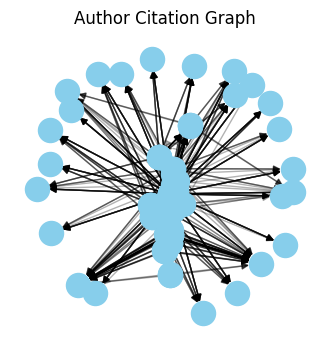

In [23]:
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G_author, seed=42)

nx.draw_networkx_nodes(G_author, pos, node_size=300, node_color="skyblue")
nx.draw_networkx_edges(G_author, pos, alpha=0.3)

plt.title("Author Citation Graph")
plt.axis("off")
plt.show()

In [24]:
def compute_hits(G, tolerance=1e-6, max_iterations=1000):
    nodes = list(G.nodes())

    # Initialize Hub and Authority Score with 1.0
    hub = {n: 1.0 for n in nodes}
    auth = {n: 1.0 for n in nodes}

    differences = []
    
    for iteration in range(max_iterations):
        auth_new = {n: sum(hub[m] for m in G.predecessors(n)) for n in nodes}
        hub_new = {n: sum(auth_new[m] for m in G.successors(n)) for n in nodes}
        norm = sum(v**2 for v in auth_new.values())**0.5
        for n in nodes:
            auth_new[n] /= norm
        norm = sum(v**2 for v in hub_new.values())**0.5   
        for n in nodes:
                hub_new[n] /= norm

        diff = sum(abs(auth_new[n]-auth[n]) + abs(hub_new[n]-hub[n]) for n in nodes)
        differences.append(diff)
        hub, auth = hub_new, auth_new
        if diff < tolerance:
            print(f"HITS converged after {iteration+1} iterations.")
            last_iteration = iteration + 1
            break
    return hub, auth , differences , last_iteration


HITS converged after 13 iterations.


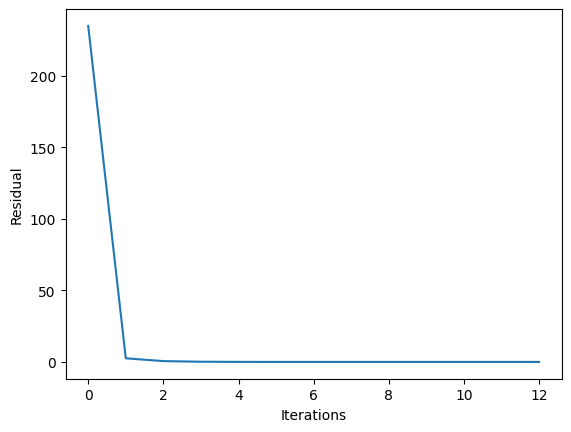

In [25]:
hub_scores, auth_scores , Differences , iterations = compute_hits(G_author)
plt.plot(np.arange(0,iterations),Differences)
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.show()

In [26]:
top_authors_by_Authorities = sorted(auth_scores.items(), key=lambda x: x[1], reverse=True)[:10]
top_authors_by_Hubs = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Authors by Authority Score:")
for i, (aid, score) in enumerate(top_authors_by_Authorities, 1):
    name = author_names.get(aid, aid)
    print(f"{i}. {name} ({aid}) → {score:.4f}")

print("\nTop 10 Authors by Hub Score:")
for i, (aid, score) in enumerate(top_authors_by_Hubs, 1):
    name = author_names.get(aid, aid)
    print(f"{i}. {name} ({aid}) → {score:.4f}")

Top 10 Authors by Authority Score:
1. Kyunghyun Cho (1979489) → 0.1785
2. Yoshua Bengio (1751762) → 0.1785
3. Dzmitry Bahdanau (3335364) → 0.1756
4. O. Vinyals (1689108) → 0.1729
5. I. Sutskever (1701686) → 0.1729
6. Sepp Hochreiter (3308557) → 0.1703
7. J. Schmidhuber (145341374) → 0.1703
8. Quoc V. Le (2827616) → 0.1697
9. Lukasz Kaiser (40527594) → 0.1566
10. Thang Luong (1821711) → 0.1515

Top 10 Authors by Hub Score:
1. Ashish Vaswani (40348417) → 0.2190
2. Noam M. Shazeer (1846258) → 0.2190
3. Niki Parmar (3877127) → 0.2190
4. Jakob Uszkoreit (39328010) → 0.2190
5. Llion Jones (145024664) → 0.2190
6. Aidan N. Gomez (19177000) → 0.2190
7. Lukasz Kaiser (40527594) → 0.2190
8. I. Polosukhin (3443442) → 0.2190
9. Jonas Gehring (2401865) → 0.1647
10. Michael Auli (2325985) → 0.1647


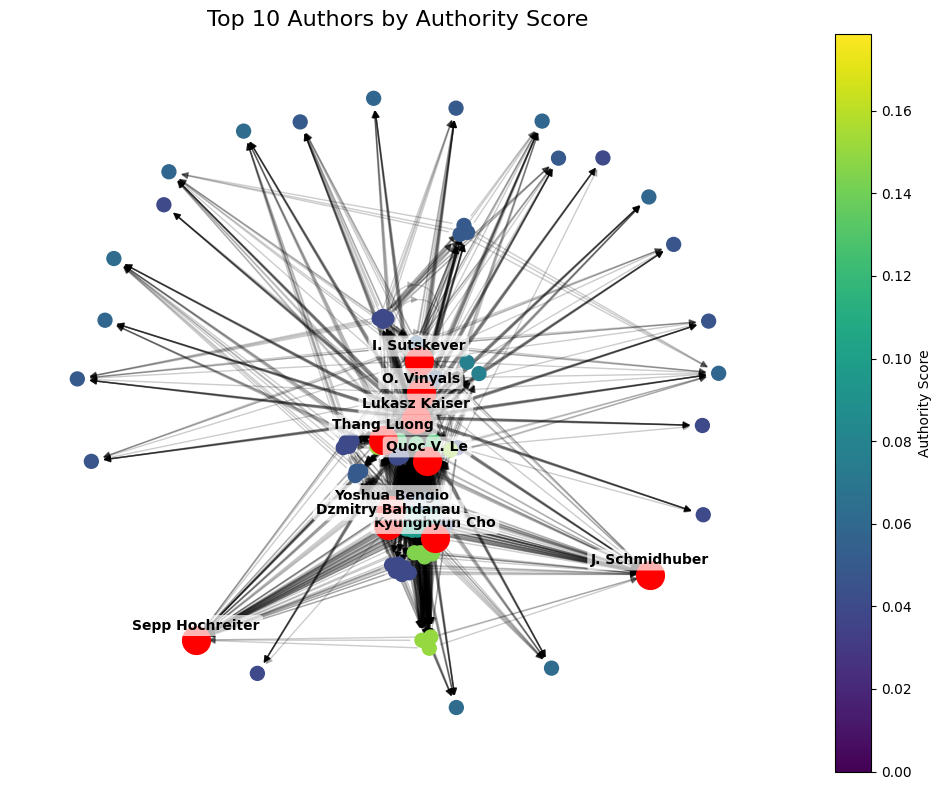

In [27]:
node_color = [auth_scores.get(n, 0) for n in G_author.nodes()]
# Top 10 authors
top_authors_by_Authorities = sorted(auth_scores.items(), key=lambda x: x[1], reverse=True)[:10]
top_author_nodes = [aid for aid, score in top_authors_by_Authorities]

pos = nx.spring_layout(G_author, seed=42, k=0.5, iterations=100)
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_nodes(G_author, pos, node_size=100, node_color=node_color, cmap=plt.cm.viridis, ax=ax)
nx.draw_networkx_edges(G_author, pos, alpha=0.2, ax=ax)
# Draw top 10 nodes bigger
nx.draw_networkx_nodes(G_author, pos, nodelist=top_author_nodes, node_size=400, node_color="red", ax=ax)

for n in top_author_nodes:
    x, y = pos[n]
    name = author_names.get(n, n)
    plt.text(
        x, y + 0.03,              
        name[:25] + ("..." if len(name) > 25 else ""), 
        fontsize=10,
        color="black",
        fontweight="bold",
        ha="center",
        bbox=dict(
            facecolor="white",
            alpha=0.7,
            edgecolor="none",
            boxstyle="round,pad=0.25"
        )
    )
sm = mpl.cm.ScalarMappable(cmap=plt.cm.viridis,
                           norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Authority Score")

ax.set_title("Top 10 Authors by Authority Score", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

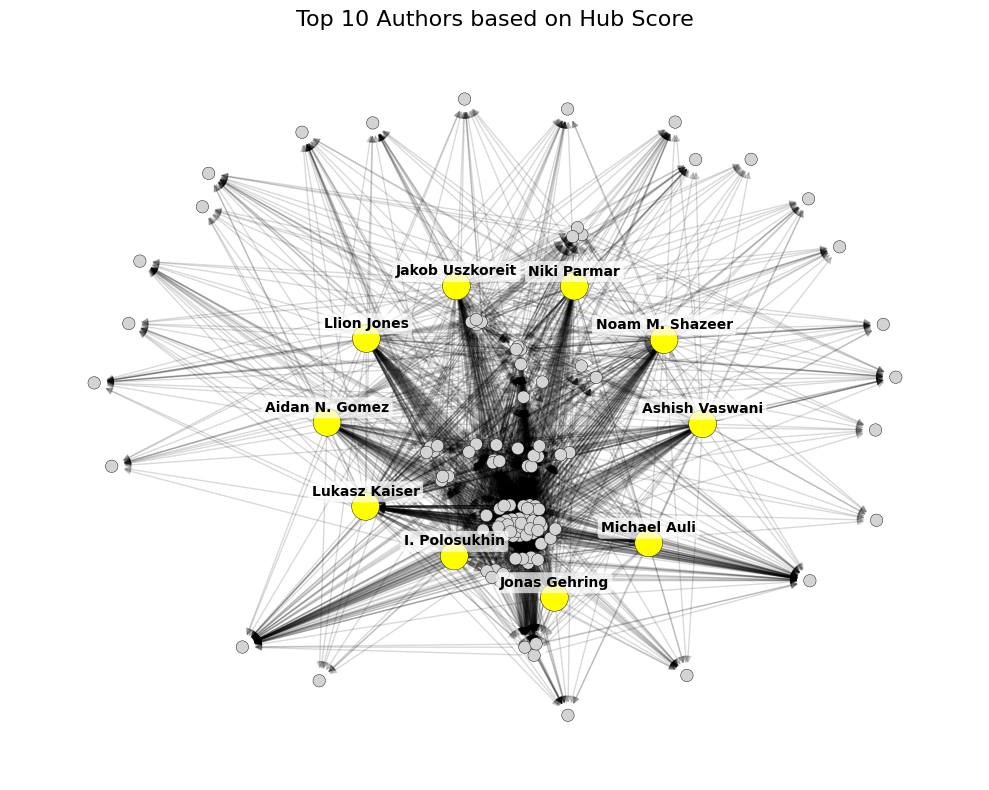

In [28]:
# Get top 10 authors by hub score
top_authors_by_Hubs = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)[:10]
top_author_nodes = [aid for aid, score in top_authors_by_Hubs]
# Compute initial layout
pos = nx.spring_layout(G_author, seed=42, k=0.5, iterations=100)

# Push top 10 nodes slightly apart
for i, n in enumerate(top_author_nodes):
    angle = 2 * np.pi * i / len(top_author_nodes)  # spread in a circle
    pos[n][0] += 0.4 * np.cos(angle)  # adjust x
    pos[n][1] += 0.4 * np.sin(angle)  # adjust y

# Node colors and sizes
node_color = ["yellow" if n in top_author_nodes else "lightgray" for n in G_author.nodes()]
node_size = [400 if n in top_author_nodes else 80 for n in G_author.nodes()]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_edges(G_author, pos, alpha=0.15, ax=ax)
nx.draw_networkx_nodes(G_author, pos, node_size=node_size, node_color=node_color, ax=ax, edgecolors="black", linewidths=0.3)

# Label the top 10 authors
for n in top_author_nodes:
    x, y = pos[n]
    name = author_names.get(n, n)
    plt.text(
        x, y + 0.03,
        name[:25] + ("..." if len(name) > 25 else ""),
        fontsize=10,
        color="black",
        fontweight="bold",
        ha="center",
        bbox=dict(
            facecolor="white",
            alpha=0.7,
            edgecolor="none",
            boxstyle="round,pad=0.25"
        )
    )

ax.set_title("Top 10 Authors based on Hub Score", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()